# Import libaries

In [4]:
# import self written libraries. These have to be in the same folder or the parent directory.
import sys, os
sys.path.append('./library/')
import reconstruct as rec
import fth_reconstruction as fth
import pymaxi as maxi

import numpy as np
import matplotlib.pyplot as plt

#interactive stuff
import ipywidgets as widgets
from IPython.display import display
import ipython_blocking

from imp import reload

In [5]:
%matplotlib notebook

# Load images

Input the image numbers, first the positive helicity image followed by the negative helicity image. If you want to do a single helicity reconstruction, then put $\mathtt{np.nan}$ into the spot, where no image is. Please specify which config file you want to use.

You must also specify whether you want to use an autofactor when substracting the images (or the topography when doing a single helicity reconstruction -- recomended!) and which parameters you want to change (propagation, ROI, beamstop). Just set the according values to True/False.

Input the file folders for the data, the matlab files and where the results are saved (check, if this is correct, especially when switching from Linux to Windows and vice versa!).

**You can execute the integrity of the following code with -> "Cell" -> "Run Cells Below". Some interaction is needed and the code will stop there and resume when you are finished.**

In [7]:
experimental_setup = {'ccd_dist': 18e-2, 'energy': 779.5, 'px_size' : 20e-6}

In [8]:
images = np.array([135, np.nan])
topo = np.array([131, 130])
conf_nr = 131

fname = 'FB0027'

autoFactor = True
propagate = True
ROI = False
beamstop = False

In [9]:
folder  =r'/home/gerlinger/Dokumente/Beamtimes/2020-06_P04/raw/'
conf_folder = '/home/gerlinger/Dokumente/Beamtimes/2020-06_P04/processed/%s/' %fname

Determine whether a double helicity or single helicity (positive or negative) is done

Load the images, add them up, shift the center.

Returns the shifted hologram, the center coordinates the beamstop diameter and the propagation distance from the config file.

In [10]:
if np.isnan(images[0]):
    im = images[1].astype(np.int)
    neg = maxi.get_mte(folder + '%s.h5'%fname, im)
    pos = None
    topo_data = maxi.get_mte(folder + '%s.h5'%fname, topo[0]) + maxi.get_mte(folder + '%s.h5'%fname, topo[1])
    hel = False
elif np.isnan(images[1]):
    im = images[0].astype(np.int)
    pos = maxi.get_mte(folder + '%s.h5'%fname, im)
    neg = None
    topo_data = maxi.get_mte(folder + '%s.h5'%fname, topo[0]) + maxi.get_mte(folder + '%s.h5'%fname, topo[1])
else:
    image = images.astype(np.int)
    neg = maxi.get_mte(folder + '%s.h5'%fname, image[1])
    pos = maxi.get_mte(folder + '%s.h5'%fname, image[0])
    hel = None
    topo_data = None
    im = image[0]

holo, factor, center, bs_diam, roi, prop_dist, phase = rec.fromParameters(pos, neg, conf_folder + 'P04_0620_%s-%d.hdf'%(fname,conf_nr),
                                                                              new_bs=beamstop, old_prop= not(propagate),
                                                                              topo = topo_data, auto_factor=autoFactor, experimental_setup = experimental_setup)

Auto factor = 0.47893664040500883
Start reconstructing the image using the center and beamstop mask from the Matlab reconstruction.
Shifted image by 36 pixels in x and 0 pixels in y.
Using beamstop diameter 50 from config file and a sigma of 10.
Please use the propagation function to propagate.


# Cosmic Rays

In [34]:
# fig, ax = plt.subplots(figsize = (8, 8))
# ax.imshow(np.abs(holo)>1000)

In [35]:
# holo = remove_two(holo, [1126, 1127], 1888)

# holo = fth.remove_cosmic_ray(holo, [290, 642])

In [36]:
# holo = np.delete(holo, 68, axis = 1)
# holo = np.delete(holo, 0, axis = 0)

In [37]:
# holo[1851, 1941:1949] = holo[1852, 1941:1949]
# holo[1850, 1951:1960] = holo[1849, 1951:1960]

# Beamstop

You may change the beamstop diameter in the text widget below the following cell. The default value in the field is the beamstop diameter from the config file.

Click on the button when you are finished to resume the execution of the code. 

In [11]:
if beamstop:
    bs_input, bs_button = rec.change_beamstop(bs_diam)

In [12]:
if beamstop:    
    %block bs_button

In [13]:
if beamstop:
    bs_diam = bs_input.value
    holo = rec.set_beamstop(holo, bs_diam)

In [14]:
if np.logical_and(beamstop, not propagate):
    holo = fth.propagate(holo, prop_dist*1e-6)

# High pass filter

Reduces large modulations in the center of the hologram.

<IPython.core.display.Javascript object>


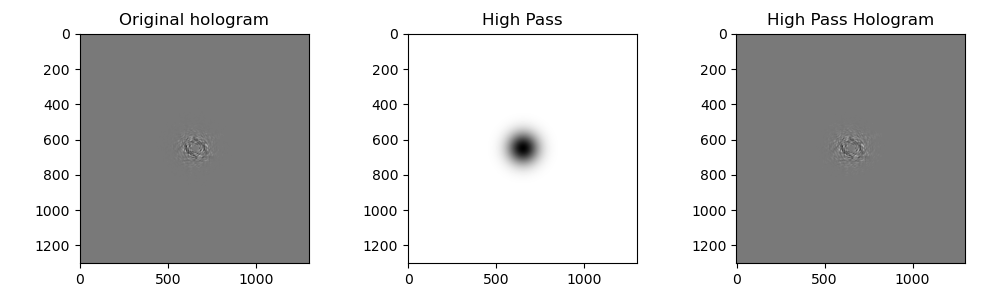

interactive(children=(FloatSlider(value=0.5, description='amplitude', layout=Layout(width='90%'), max=1.0, ste…

In [15]:
slider_amp, slider_sig = rec.high_pass_filtering(holo)

In [16]:
amplitude = slider_amp.value
sigma = slider_sig.value

In [17]:
holo, _ = fth.highpass(holo, amplitude, sigma)

# ROI

You may select the reconstruction you want to look at. Do this by zooming into the image and putting in the x and y coordinates of the start and end points of your ROI.

Click on the button when you are finished to resume the execution of the code. 

In [18]:
if ROI:
    fig, ax = fth.plot(np.real(fth.reconstruct(holo)), colorbar = False, scale = (2,98))

In [19]:
if ROI:
    x1, x2 = ax.get_xlim()
    y2, y1 = ax.get_ylim()
    roi = np.array([fth.integer(x1), fth.integer(x2), fth.integer(y1), fth.integer(y2)]) #xstart, xstop, ystart, ystop

# Subpixel centering, propagation, phase

Now, the hologram can be propagated. Use the slider "propagation" and chose a value for which the image is sharp.

Then you need to apply a global phase shift to the image, to get all the information into one part of the complex image (usually the real part).

Also to get rid of slight ramps in the reconstruction a subpixel shift can be applied.

Do not forget to save the slider values and to apply the subpixel shift.

<IPython.core.display.Javascript object>


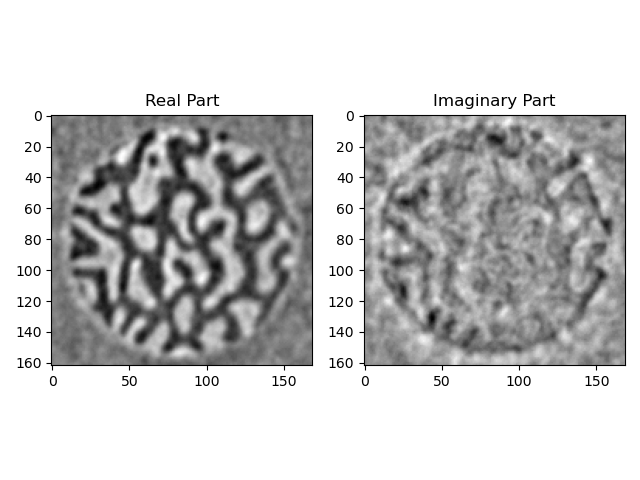

interactive(children=(FloatSlider(value=1.62, description='propagation[um]', layout=Layout(width='90%'), max=1…

In [20]:
slider_prop, slider_phase, slider_dx, slider_dy = rec.sub_pixel_centering(holo, roi, phase, prop_dist, experimental_setup = experimental_setup)

In [21]:
prop_dist=slider_prop.value
phase = slider_phase.value
dx = slider_dx.value
dy = slider_dy.value

# Reconstruct

In [22]:
image = fth.reconstruct(fth.propagate(holo, prop_dist*1e-6, experimental_setup)*np.exp(1j*phase))
recon = fth.sub_pixel_centering(image, dx, dy)[roi[2]:roi[3], roi[0]:roi[1]]

Propagation distance: 1.62um


# TV minimization

Use the TV minimization written by Erik Malm, a doctoral researcher at Lund University, to smoothen your hologram and improve its quality.

**This might take a few minutes to compute.**

In [24]:
it = 40000
stps = 1e-3

In [25]:
recon_tv = rec.tv_minimize(recon, bs_diam, holo.shape, iterations = it, step_size = stps)

Your reconstruction FOV is not quadratic, will adjust now!


In [43]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.real(recon), cmap = 'gray')
ax[0].set_axis_off()
ax[0].set_title('Before TV')

ax[1].imshow(np.real(recon_tv), cmap = 'gray')
ax[1].set_axis_off()
ax[1].set_title('After TV')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'After TV')

# Save

Save the reconstruction (only the selected ROI) as a numpy array and all the parameters in a config file.

In [26]:
folder_save = r'C:\Users\gerlinge\Documents\Projects\OpticalSK-XFEL_paper1920\Reconstructions/'

if not(os.path.exists(folder_save)):
    print("Creating folder " + folder_save)
    os.mkdir(folder_save)

Creating folder C:\Users\gerlinge\Documents\Projects\OpticalSK-XFEL_paper1920\Reconstructions/


<IPython.core.display.Javascript object>


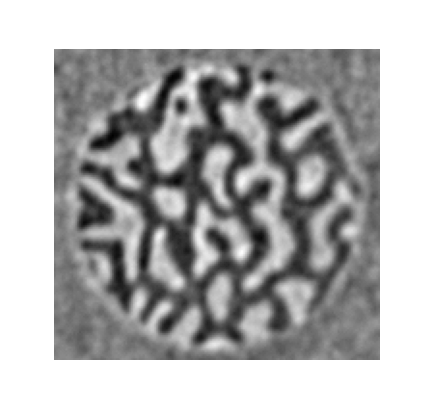

In [27]:
fig, ax = plt.subplots(frameon = False, figsize = (recon.shape[1] / 40, recon.shape[0] / 40))
ax.imshow(np.real(recon), cmap = 'gray')
ax.set_axis_off()
# ax.annotate('%s-%d'%(fname, im), (.02, .95), xycoords = 'axes fraction', bbox = {'alpha': .5, 'ec': None, 'fc': 'w', 'lw': None})
# plt.savefig(folder_save + 'P04_0620_%s-%d.png'%(fname,im), bbox_inches='tight', dpi = 300)

In [28]:
if topo is None:
    topo_save = [np.nan, np.nan]
else:
    topo_save = topo

In [29]:
comment = 'Fine Tuning Tryout'

In [30]:
dic_save = {
        'reconstruction': recon,
        'image numbers': images,
        'topo numbers': topo,
        'factor': factor,
        'center': center,
        'beamstop diameter': bs_diam,
        'ROI coordinates': roi,
        'Propagation distance': prop_dist,
        'phase': phase,
        'highpass sigma': sigma,
        'highpass amplitude': amplitude,
        'subpixel shift': [dx, dy],
        'TV min. iterations': it,
        'TV min. step size': stps,
        'comment': comment
    }

In [33]:
fth.save_reco_dict_to_hdf(folder_save + 'P04_0620_%s-%d.hdf'%(fname,im), dic_save, key = 'FineTuning')

'FineTuning01'

In [21]:
plt.close('all')